<a href="https://colab.research.google.com/github/Viliuskerutis/AML/blob/main/AML_MP3_Kerutis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 3: Viral prediction

Date: 2020.12.14

Author: © 2020 [Vilius Kerutis](https://www.google.com/search?q=Vilius+Kerutis&oq=Vilius+Kerutis)  
Template author: © 2020 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

Here we analyze open COVID-19 data from https://ourworldindata.org/coronavirus.

## Load the data

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [2]:
#'''
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)
#''';

13368266

Load the file to Pandas.

In [3]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

The time series to predict.

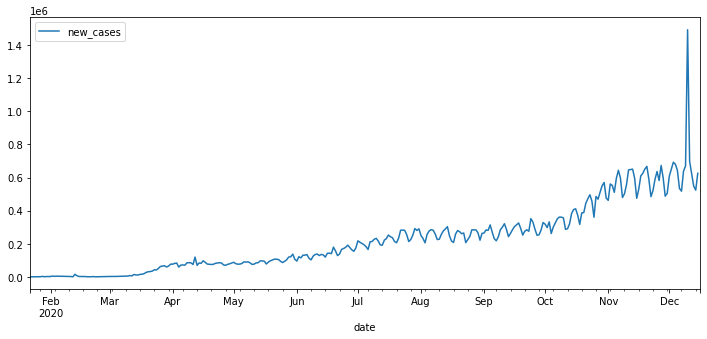

In [4]:
column = 'new_cases'
time_series = df[df.iso_code=='OWID_WRL'][['date',column]].set_index('date')
time_series.plot(figsize=(12,5),logy=False)

Error measure used to evaluate your solution is Root Mean Square Log Error (RMSLE), square-root of 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error.

In [5]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Split the data into training and testing. You can temporality fix the dates in your experiments.

In [6]:
from datetime import timedelta
# last_date will be 2020-12-23 in final testing, and other dates set accordingly 
last_semester_date = pd.Timestamp('2020-12-15') # buvo 23
last_date = time_series.index[-1]
if last_date >= last_semester_date:
    last_date = last_semester_date #  # 
    print("We can test now!")
# will be 2020-12-16 - the last date available before your dedline: end of 2020-12-17
last_training_date = last_date - timedelta(days=7) 
first_prediction_date = last_date - timedelta(days=6)
last_prediction_date = last_date
(last_training_date, first_prediction_date, last_prediction_date)

We can test now!


(Timestamp('2020-12-08 00:00:00'),
 Timestamp('2020-12-09 00:00:00'),
 Timestamp('2020-12-15 00:00:00'))

In [7]:
training_time_series = time_series[:last_training_date]
testing_time_series = time_series[first_prediction_date:last_prediction_date]

# My models

I have tried several methods to deal with time-series predictions. Some of them did not work at all. The first one worked pretty fine but the result was too good - score = 1 - I think there was made a logical mistake but we have what we have.

https://microsoft.github.io/sql-ml-tutorials/python/rentalprediction/step/2.html

    model = LinearRegression()
    model.fit(train_data, train_data)
    pred = model.predict(train_data)

https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [8]:
def my_best_method1(train_data):
    pipe0 = Pipeline([('scaler', StandardScaler()), ('svc', LinearRegression())])
    pipe0 = pipe0.fit(train_data.iloc[50:], train_data.iloc[:50,[0]])
    score = pipe0.score(train_data.iloc[:7], train_data.iloc[:7,[0]])
    train_data['predicted'] = pipe0.predict(testing_time_series.values)
    return train_data

## A simple persistency model 

Returns the last week as the prediction for the next one. 

Validation MRSLE with last_date=2020-12-07 is 0.07974867401899698. Training time: negligible. No hyper parameter optimization tried.

In [9]:
def get_last_week(train_data):
    return train_data[-7:]

## Standard Facebook Prophet prediction library

Taken from https://facebook.github.io/prophet/.

Validation MRSLE with last_date=2020-12-07 is 0.11099341341289806. Training time: 1.55 ms on Colab . No hyper parameter optimization tried.

In [10]:
# Install a pip package in the current Jupyter kernel if it's not present (takes some time). It is
# It is present in Colab.
# from https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
# import sys
# !{sys.executable} -m pip install pystan
# !{sys.executable} -m pip install fbprophet
from fbprophet import Prophet
def use_fb_prophet(train_data):
    m = Prophet()
    # the data must have the specific columns
    a = train_data.reset_index()
    b = a.rename(columns={'date': 'ds', 'new_cases': 'y'})

    m.fit(b)
    prediction_dates = m.make_future_dataframe(periods=7, include_history=False) 
    prediction = m.predict(prediction_dates)
    # and be formated back
    return prediction.set_index('ds')['yhat']

## Another model

Validation types, variations and hyper parameters tried (last_date=2020-12-07):

The results can be presented in Tables like this:

| Variation or hyper-parameter values | (Cross?-)Validation accuracy |
|-------|------------------------------|
| Linear Regresion |    6.713997766802521e-16                 |

More on formatting markdown: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet


...

## My main best model

Was selected to be ...


In [11]:
def my_best_method(train_data):
    pipe0 = Pipeline([('scaler', StandardScaler()), ('svc', LinearRegression())])
    pipe0 = pipe0.fit(train_data, train_data)
    score = pipe0.score(train_data.iloc[:7], train_data.iloc[:7,[0]])
    future_prognosis = pipe0.predict(testing_time_series)
    return get_last_week(future_prognosis)

# Testing / validation

Do not edit beyound this point!

Run the training and prediction with your best model:

In [12]:
import time
start_time = time.time()

predicted_time_series = my_best_method(training_time_series)

end_time = time.time()
elapsed_time = end_time - start_time
max_training_time = 3*60
print('Predicting time: %.2f s (max %i s.)' %(elapsed_time, max_training_time))  
assert elapsed_time <= max_training_time, 'Training is too long!'
pred_fb = use_fb_prophet(training_time_series)

Predicting time: 0.03 s (max 180 s.)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
pred_fb

ds
2020-12-09    677768.712740
2020-12-10    689993.056840
2020-12-11    698362.572959
2020-12-12    682615.498159
2020-12-13    654737.136683
2020-12-14    666797.954711
2020-12-15    691237.340155
Name: yhat, dtype: float64

In [14]:
predicted_time_series

array([[ 670367.],
       [1492534.],
       [ 697499.],
       [ 624701.],
       [ 548237.],
       [ 523616.],
       [ 625480.]])

In [15]:
training_time_series

,new_cases
date,
2020-01-22,0.0
2020-01-23,96.0
2020-01-24,285.0
2020-01-25,489.0
2020-01-26,679.0
...,...
2020-12-04,680168.0
2020-12-05,642052.0
2020-12-06,534285.0


In [16]:
testing_time_series

,new_cases
date,
2020-12-09,670367.0
2020-12-10,1492534.0
2020-12-11,697499.0
2020-12-12,624701.0
2020-12-13,548237.0
2020-12-14,523616.0
2020-12-15,625480.0


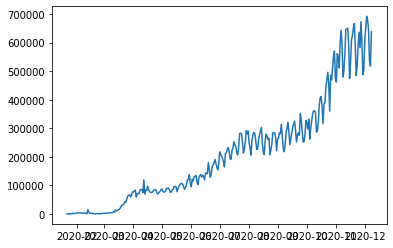

In [17]:
plt.plot(training_time_series) # plotting by columns
plt.show()

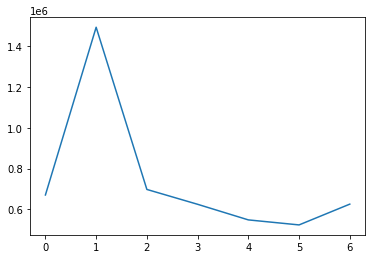

In [18]:
plt.plot(predicted_time_series) # plotting by columns
plt.show()

Compute the error of your best model:

In [19]:
RMSLE(testing_time_series, predicted_time_series)

6.713997766802521e-16

## Information on the obtained hardware

Only relavant if execution time is in question: then it is tested on Colab T100 node, just as in MP2.

In [20]:
import os
osname = os.name
print(osname)
if osname == 'posix':
    f = os.popen('nvidia-smi')
    print(f.read())

    f = os.popen('lscpu')
    print(f.read())
elif osname == 'nt':
    # from https://winaero.com/get-cpu-information-via-command-prompt-in-windows-10/
    f = os.popen('wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status')
    print(f.read())

posix
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_k

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
